In [14]:
using RigidBodyDynamics
using ForwardDiff
using Plots

In [4]:
struct Model
    f::Function # continuous dynamics (ie, differential equation)
    n::Int # number of states
    m::Int # number of controls

    function Model(f::Function, n::Int64, m::Int64)
        # construct a model from an explicit differential equation
        new(f,n,m)
    end

    function Model(mech::Mechanism)
        # fully actuated
        m = length(joints(mech))-1  # subtract off joint to world
        Model(mech,ones(m,1))
    end

    function Model(mech::Mechanism,torques::Array)

        # construct a model using robot dynamics equation assembed from URDF file
        n = num_positions(mech) + num_velocities(mech) + num_additional_states(mech)
        num_joints = length(joints(mech))-1  # subtract off joint to world
        m = num_joints # Default to number of joints

        function fc(x,u)
            state = MechanismState{eltype(x)}(mech)

            # set the state variables:
            q = x[1:num_joints]
            qd = x[(1:num_joints)+num_joints]
            set_configuration!(state, q)
            set_velocity!(state, qd)

            [qd; Array(mass_matrix(state))\(torques.*u) - Array(mass_matrix(state))\Array(dynamics_bias(state))]
        end
        new(fc, n, convert(Int,sum(torques)))
    end
end

function Model(urdf::String)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech)
end

function Model(urdf::String,torques::Array{Float64,1})
    # underactuated system (potentially)
    # construct modeling using string to urdf file
    mech = parse_urdf(Float64,urdf)
    Model(mech,torques)
end

Model

In [5]:
# cost function
struct Objective
    Q::Array{Float64,2}
    R::Array{Float64,2}
    Qf::Array{Float64,2}
    tf::Float64
    x0::Array{Float64,1}
    xf::Array{Float64,1}
end

In [6]:
struct Solver
    model::Model
    obj::Objective
    dt::Float64
    fd::Function  # discrete dynamics
    F::Function
    N::Int

    function Solver(model::Model, obj::Objective, discretizer::Function=rk4; dt=0.01)
        fd = discretizer(model.f, dt)     # Discrete dynamics
        f_aug = f_augmented(model)  # Augmented continuous dynamics
        fd_aug = discretizer(f_aug)  # Augmented discrete dynamics
        F(S) = ForwardDiff.jacobian(fd_aug, S)

        function Jacobians(x::Array,u::Array)
            F_aug = F([x;u;dt])
            fx = F_aug[1:model.n,1:model.n]
            fu = F_aug[1:model.n,model.n+1:model.n+model.m]
            return fx, fu
        end

        N = Int(floor(obj.tf/dt));
        new(model, obj, dt, fd, Jacobians, N)
    end
end

# Midpoint Integrator
function f_midpoint(f::Function, dt::Float64)
    dynamics_midpoint(x,u)  = x + f(x + f(x,u)*dt/2, u)*dt
end

function f_midpoint(f::Function)
    dynamics_midpoint(S::Array)  = S + f(S + f(S)*S[end]/2)*S[end]
end

# RK4 Integrator
function rk4(f::Function,dt::Float64)
    # Runge-Kutta 4
    k1(x,u) = dt*f(x,u)
    k2(x,u) = dt*f(x + k1(x,u)/2.,u)
    k3(x,u) = dt*f(x + k2(x,u)/2.,u)
    k4(x,u) = dt*f(x + k3(x,u), u)
    fd(x,u) = x + (k1(x,u) + 2.*k2(x,u) + 2.*k3(x,u) + k4(x,u))/6.
end

function rk4(f_aug::Function)
    # Runge-Kutta 4
    fd(S::Array) = begin
        k1(S) = S[end]*f_aug(S)
        k2(S) = S[end]*f_aug(S + k1(S)/2.)
        k3(S) = S[end]*f_aug(S + k2(S)/2.)
        k4(S) = S[end]*f_aug(S + k3(S))
        S + (k1(S) + 2.*k2(S) + 2.*k3(S) + k4(S))/6.
    end
end

# Assembled augmented function
function f_augmented(model::Model)
    f_aug = f_augmented(model.f, model.n, model.m)
    f(S::Array) = [f_aug(S); zeros(model.m+1,1)]
end

function f_augmented(f::Function, n::Int, m::Int)
    f_aug(S::Array) = f(S[1:n], S[n+(1:m)])
end

f_augmented (generic function with 2 methods)

In [41]:
#iLQR
function rollout!(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    X[:,1] = solver.obj.x0
    for k = 1:solver.N-1
        X[:,k+1] = solver.fd(X[:,k],U[:,k])
    end
end

function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
    N = solver.N
    X_[:,1] = solver.obj.x0;
    for k = 2:N
        a = alpha*(d[:,k-1]);
        delta = (X_[:,k-1] - X[:,k-1])

        U_[:, k-1] = U[:, k-1] - K[:,:,k-1]*delta - a;
        X_[:,k] = solver.fd(X_[:,k-1], U_[:,k-1]);
    end
end

function rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, alpha::Float64)
    N = solver.N
    X_ = zeros(solver.model.n, N);
    U_ = zeros(solver.model.m, N)
    rollout!(solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2},
        alpha::Float64, X_::Array{Float64,2}, U_::Array{Float64,2})
    return X_, U_
end

function cost(solver::Solver,X::Array{Float64,2},U::Array{Float64,2})
    N = solver.N
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    J = 0.0
    for k = 1:N-1
      J += 0.5*(X[:,k] - xf)'*Q*(X[:,k] - xf) + 0.5*U[:,k]'*R*U[:,k]
    end
    J += 0.5*(X[:,N] - xf)'*Qf*(X[:,N] - xf)
    return J
end

function backwardpass(solver::Solver,X::Array{Float64,2},U::Array{Float64,2},K::Array{Float64,3},d::Array{Float64,2})
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    Q = solver.obj.Q
    R = solver.obj.R
    xf = solver.obj.xf
    Qf = solver.obj.Qf

    S = Qf
    s = Qf*(X[:,N] - xf)
    v1 = 0.
    v2 = 0.

    mu = 0.
    k = N-1
    while k >= 1
        lx = Q*(X[:,k] - xf)
        lu = R*(U[:,k])
        lxx = Q
        luu = R
        fx, fu = solver.F(X[:,k],U[:,k])
        Qx = lx + fx'*s
        Qu = lu + fu'*s
        Qxx = lxx + fx'*S*fx
        Quu = luu + fu'*(S + mu*eye(n))*fu
        Qux = fu'*(S + mu*eye(n))*fx

        # regularization
        if any(eigvals(Quu).<0.)
            mu = mu + 1.0;
            k = N-1;
            println("regularized")
        end

        K[:,:,k] = Quu\Qux
        d[:,k] = Quu\Qu
        s = (Qx' - Qu'*K[:,:,k] + d[:,k]'*Quu*K[:,:,k] - d[:,k]'*Qux)'
        S = Qxx + K[:,:,k]'*Quu*K[:,:,k] - K[:,:,k]'*Qux - Qux'*K[:,:,k]

        # terms for line search
        v1 += float(d[:,k]'*Qu)[1]
        v2 += float(d[:,k]'*Quu*d[:,k])

        k = k - 1;
    end
    return K, d, v1, v2
end

function forwardpass!(X_, U_, solver::Solver, X::Array{Float64,2}, U::Array{Float64,2}, K::Array{Float64,3}, d::Array{Float64,2}, v1::Float64, v2::Float64, c1::Float64=0.5, c2::Float64=0.85)

    # Compute original cost
    J_prev = cost(solver, X, U)

    J = Inf
    alpha = 1.0
    iter = 0
    dV = Inf
    z = 0.

    while z < c1 || z > c2
        rollout!(solver, X, U, K, d, alpha, X_, U_)

        # Calcuate cost
        J = cost(solver, X_, U_)

        dV = alpha*v1 + (alpha^2)*v2/2.
        z = (J_prev - J)/dV[1,1]
        alpha = alpha/2.
        iter = iter + 1

        if iter > 25
            println("max iterations (forward pass)")
            break
        end
        iter += 1
    end

#     println("New cost: $J")
#     println("- Expected improvement: $(dV[1])")
#     println("- Actual improvement: $(J_prev-J)")
#     println("- (z = $z)\n")

    return J

end

function solve(solver::Solver)
    U = zeros(solver.model.m, solver.N)
    solve(solver,U)
end

function solve(solver::Solver,U::Array{Float64,2},iterations::Int64=100,eps::Float64=1e-3)
    N = solver.N
    n = solver.model.n
    m = solver.model.m
    X = zeros(n,N)
    X_ = similar(X)
    U_ = similar(U)
    K = zeros(m,n,N-1)
    d = zeros(m,N-1)

    X[:,1] = solver.obj.x0

    # initial roll-out
    rollout!(solver, X, U)
    J_prev = cost(solver, X, U)
    println("Initial Cost: $J_prev\n")

    for i = 1:iterations
#         println("*** Iteration: $i ***")
        K, d, v1, v2 = backwardpass(solver,X,U,K,d)
        J = forwardpass!(X_, U_, solver, X, U, K, d, v1, v2)

        X = copy(X_)
        U = copy(U_)

        if abs(J-J_prev) < eps
            println("-----SOLVED-----")
            println("New cost: $J")
            println("eps criteria met at iteration: $i")
            break
        end

        J_prev = copy(J)
    end

    return X, U
end

solve (generic function with 4 methods)

In [42]:
## Simple Pendulum
# https://github.com/HarvardAgileRoboticsLab/unscented-dynamic-programming/blob/master/pendulum_dynamics.m
function pendulum_dynamics(x,u)
    m = 1.
    l = 0.5
    b = 0.1
    lc = 0.5
    I = 0.25
    g = 9.81
    return [x[2]; (u - m*g*lc*sin(x[1]) - b*x[2])];
end
model = Model(pendulum_dynamics,2,1)

Model(pendulum_dynamics, 2, 1)

In [63]:
x0 = [0.; 0.]
xf = [pi; 0.] # (ie, swing up)

#costs
Q = 1e-3*eye(model.n)
Qf = 30.0*eye(model.n)
R = 1e-3*eye(model.m)

#simulation
dt = 0.01
tf = 5.0

obj = Objective(Q,R,Qf,tf,x0,xf)
solver = Solver(model,obj,dt=dt)

Solver(Model(pendulum_dynamics, 2, 1), Objective([0.001 0.0; 0.0 0.001], [0.001], [30.0 0.0; 0.0 30.0], 5.0, [0.0, 0.0], [3.14159, 0.0]), 0.01, fd, Jacobians, 500)

In [64]:
U = 5.*rand(solver.model.m,solver.N)
X_pendulum, U_pendulum = @time solve(solver,U);

Initial Cost: 73.45794970340664

-----SOLVED-----
New cost: 1.9333213617521798
eps criteria met at iteration: 50
 10.782283 seconds (34.84 M allocations: 1.806 GiB, 16.98% gc time)


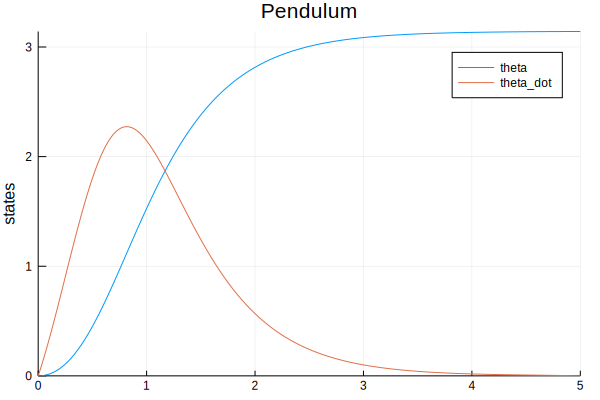

In [65]:
plot(linspace(0,tf,solver.N),X_pendulum[1,:],label="theta")
plot!(linspace(0,tf,solver.N),X_pendulum[2,:],label="theta_dot",title="Pendulum",ylabel="states")

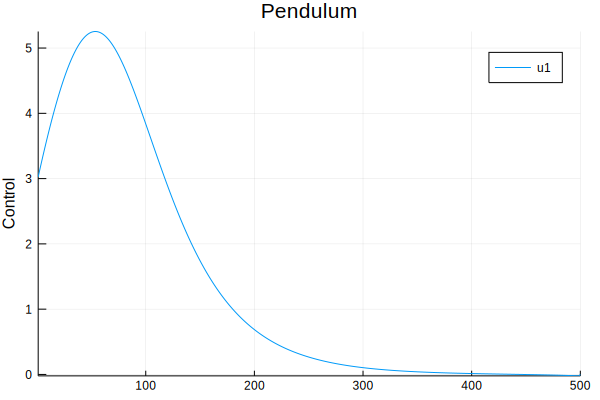

In [66]:
plot(U_pendulum',title="Pendulum",ylabel="Control",label="u1")